# CAM - XAI Technique

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline

In [ ]:
model = keras.applications.xception.Xception(weights="imagenet")

#  Brain tumor image

In [ ]:
img_path = keras.utils.get_file(
    fname = 'Brain Tumor',
    origin = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Hirnmetastase_MRT-T1_KM.jpg/300px-Hirnmetastase_MRT-T1_KM.jpg')

def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array = keras.applications.xception.preprocess_input(array)
  return array
  
img_array = get_img_array(img_path, target_size=(299, 299))

15874/15874 [==============================] - 0s 0us/step


In [ ]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [ ]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  tape.watch(last_conv_layer_output)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]
  heatmap = np.mean(last_conv_layer_output, axis=-1)

(-0.5, 9.5, 9.5, -0.5)

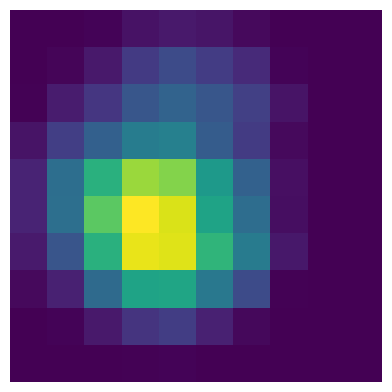

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.axis('off')

In [ ]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "/content/gdrive/MyDrive/tumor2_cam.jpg"
superimposed_img.save(save_path)

<ipython-input-29-767738e3332b>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


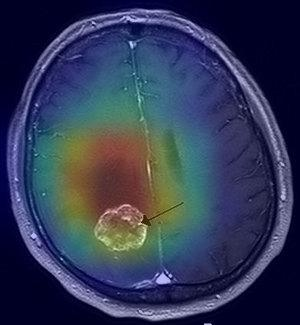

In [ ]:
from IPython.display import Image
display(Image(filename='/content/gdrive/MyDrive/tumor2_cam.jpg', width = 400))

Reference: Deep Learning with Python - Manning Publications (2021) - François Chollet